In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import cv2
import supervision as sv

In [16]:
MAX_OBJ = 8 # max cards to try to include
OVERLAP_DEGREE = 0.2 # extent to which cards can overlap
MAX_ATTEMPTS_PER_OBJ = 100 # number of tries for card insertion before giving up
ADD_THRESHOLD = 0.9 # amount of card that should remain in screen
SCALE_MIN = 0.1 # minimum size to rescale card to
SCALE_MAX = 0.25 # max size to rescale card to
PERSPECTIVE_TRANSFORM_EXTENT = 0.3 # max extent to warp perspective by

def get_mask(image):
    # Extract the alpha channel (transparency)
    if image.shape[2] == 4: 
        alpha_channel = image[:, :, 3]
        # Create a binary mask: 1 where pixel is not transparent, 0 where transparent
        binary_mask = (alpha_channel > 0).astype(np.uint8)
    else:
        binary_mask = np.ones((image.shape[0], image.shape[1]), dtype=np.uint8)
    return binary_mask

def resize_bg(image):
    # Step 1: Resize while preserving aspect ratio
    h, w = image.shape[:2]
    aspect_ratio = w / h

    # Resize so that the longer side fits the target size, keeping aspect ratio
    if aspect_ratio > 1:  # Wider than tall
        new_h = 640
        new_w = int(new_h * aspect_ratio)
    else:  # Taller than wide or square
        new_w = 640
        new_h = int(new_w / aspect_ratio)
    blurred_img = cv2.GaussianBlur(image, (5, 5), 0)
    resized_img = cv2.resize(blurred_img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Step 2: Crop the resized image to fit 640x640 (if necessary)
    # Calculate the center of the image to crop
    top = (new_h - 640) // 2 if new_h > 640 else 0
    left = (new_w - 640) // 2 if new_w > 640 else 0

    cropped_img = resized_img[top:top+640, left:left+640, :]
    return cropped_img

def get_rand_bg(files_bgs):
    # Ensure 640 x 640 at minimum
    while True:
        idx = np.random.randint(len(files_bgs))
        img_comp = cv2.imread(files_bgs[idx])
        if img_comp.shape[0] >= 640 and img_comp.shape[1] >= 640:
            break
    # Ensure alpha channel is present
    if img_comp.shape[2] == 3:
        alpha_channel = np.ones((img_comp.shape[0], img_comp.shape[1]), dtype=np.uint8) * 255  # Fully opaque
        img_comp = np.dstack((img_comp, alpha_channel))

    # Convert to RGBA
    img_comp = cv2.cvtColor(img_comp, cv2.COLOR_BGRA2RGBA)

    # Resize to 640 x 640
    img_comp = resize_bg(img_comp)
    
    # Get mask - all 0s
    h, w = img_comp.shape[0], img_comp.shape[1]
    mask_comp = np.zeros((h,w), dtype=np.uint8) 
    
    return img_comp, mask_comp

# Function to apply perspective transform and prevent clipping
def random_perspective_transform(img, max_transform_extent=0.3):
    h, w = img.shape[:2]
    
    # Randomly define the amount of variation for top-left and top-right corners
    horizontal_shift_top = random.randint(-int(max_transform_extent * w), int(max_transform_extent * w))
    vertical_shift_top = random.randint(-int(max_transform_extent * h), int(max_transform_extent * h))
    
    # Top-left and top-right should stay parallel
    top_left = (horizontal_shift_top, vertical_shift_top)
    top_right = (w + horizontal_shift_top, vertical_shift_top)
    
    # Randomly define the amount of variation for bottom-left and bottom-right corners
    horizontal_shift_bottom = random.randint(-int(max_transform_extent * w), int(max_transform_extent * w))
    vertical_shift_bottom = random.randint(-int(max_transform_extent * h), int(max_transform_extent * h))
    
    # Bottom-left and bottom-right should stay parallel
    bottom_left = (horizontal_shift_bottom, h + vertical_shift_bottom)
    bottom_right = (w + horizontal_shift_bottom, h + vertical_shift_bottom)
    
    # Define original rectangle
    rect_src = np.float32([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]])

    # Define the transformed rectangle
    rect_dst = np.float32([top_left, top_right, bottom_left, bottom_right])

    # Get perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(rect_src, rect_dst)

    mask = get_mask(img)

    # Calculate the maximum difference between the corners
    # Find the extreme values of x and y for the corners
    x_coords = [abs(dst[0]-src[0]) for dst, src in zip(rect_dst, rect_src)]
    y_coords = [abs(dst[1]-src[1]) for dst, src in zip(rect_dst, rect_src)]
    
    # Find the maximum difference in both x and y directions
    max_diff_x = max(x_coords)
    max_diff_y = max(y_coords)
    
    # Calculate padding amount
    padding_amount = int(max(max_diff_x, max_diff_y))

    # Pad the image on all sides by padding_amount
    if img.shape[2] == 4:
        padded_img = cv2.copyMakeBorder(img, padding_amount, padding_amount, padding_amount, padding_amount, 
                                    cv2.BORDER_CONSTANT, value=(0, 0, 0, 0))
    else:
        padded_img = cv2.copyMakeBorder(img, padding_amount, padding_amount, padding_amount, padding_amount, 
                                    cv2.BORDER_CONSTANT, value=(0, 0, 0))
    padded_mask = cv2.copyMakeBorder(mask, padding_amount, padding_amount, padding_amount, padding_amount, 
                                    cv2.BORDER_CONSTANT, value=0)

    # Recalculate the perspective transformation matrix for the padded image
    matrix = cv2.getPerspectiveTransform(rect_src + padding_amount, rect_dst + padding_amount)

    # Apply perspective transform to the padded image                                                                   
    transformed_img = cv2.warpPerspective(padded_img, matrix, (w + 2 * padding_amount, h + 2 * padding_amount))
    transformed_mask = cv2.warpPerspective(padded_mask, matrix, (w + 2 * padding_amount, h + 2 * padding_amount), 
                                       borderMode=cv2.BORDER_CONSTANT, 
                                       borderValue=0)

    # Calculate the bounding box for the transformed image
    pts = np.array([top_left, top_right, bottom_left, bottom_right], dtype=np.float32)
    rect = cv2.boundingRect(pts)  # Get bounding rectangle

    # Get the x, y, width, height of the bounding box
    x, y, w_new, h_new = rect

    # Crop the image to the bounding box (to remove padding) or resize
    cropped_img = transformed_img[padding_amount+y:padding_amount+y+h_new, padding_amount+x:padding_amount+x+w_new]
    cropped_mask = transformed_mask[padding_amount+y:padding_amount+y+h_new, padding_amount+x:padding_amount+x+w_new]

    return cropped_img, cropped_mask

def resize_card(image, mask, scale_min=0.5, scale_max=1.5):
    scale_factor = random.uniform(scale_min, scale_max)

    # Calculate the new dimensions while preserving aspect ratio
    new_width = int(image.shape[1] * scale_factor)
    new_height = int(image.shape[0] * scale_factor)

    # Resize the image using OpenCV
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    resized_mask = cv2.resize(mask, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

    return resized_image, resized_mask

def random_rotate_image(image, mask):
    """
    Randomly rotates an image and its binary mask by a random angle.

    Args:
        image (np.ndarray): The input image to rotate (can be 3 or 4 channels).
        mask (np.ndarray): The binary mask to rotate alongside the image.
    
    Returns:
        np.ndarray: The rotated image.
        np.ndarray: The rotated mask.
    """
    # Get image dimensions
    h, w = image.shape[:2]

    # Random angle between 0 and 360 degrees
    angle = np.random.uniform(0, 360)

    # Calculate the center of the image
    center = (w // 2, h // 2)

    # Compute the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Determine the bounding box of the rotated image
    cos_val = np.abs(rotation_matrix[0, 0])
    sin_val = np.abs(rotation_matrix[0, 1])

    # Compute the new bounding dimensions
    new_w = int((h * sin_val) + (w * cos_val))
    new_h = int((h * cos_val) + (w * sin_val))

    # Adjust the rotation matrix to account for the translation
    rotation_matrix[0, 2] += (new_w / 2) - center[0]
    rotation_matrix[1, 2] += (new_h / 2) - center[1]

    # Determine border value for image
    if image.shape[2] == 4:
        border_value = (0, 0, 0, 0)  # Transparent border for 4-channel images
    else:
        border_value = (0, 0, 0)  # Black border for 3-channel images

    # Rotate the image with constant border color
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_w, new_h), 
                                   borderMode=cv2.BORDER_CONSTANT, 
                                   borderValue=border_value)

    # Rotate the mask using nearest-neighbor interpolation
    rotated_mask = cv2.warpAffine(mask, rotation_matrix, (new_w, new_h), 
                                  flags=cv2.INTER_NEAREST, 
                                  borderMode=cv2.BORDER_CONSTANT, 
                                  borderValue=0)
    
    return rotated_image, rotated_mask

def get_rand_card(files_objs):
    idx = np.random.randint(len(files_objs))
    img = cv2.imread(files_objs[idx], cv2.IMREAD_UNCHANGED)
    
    if img.shape[2] == 3:
        alpha_channel = np.ones((img.shape[0], img.shape[1]), dtype=np.uint8) * 255  # Fully opaque
        img = np.dstack((img, alpha_channel))
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    
    img_t, mask_t = random_perspective_transform(img, PERSPECTIVE_TRANSFORM_EXTENT)
    img_t, mask_t = random_rotate_image(img_t, mask_t)
    img_t, mask_t = resize_card(img_t, mask_t, scale_min=SCALE_MIN, scale_max=SCALE_MAX)
    # visualize_alpha(img_t)
    return img_t, mask_t


def add_obj(img_comp, mask_comp, img, mask, idx):
    '''
    img_comp - composition of objects
    mask_comp - composition of objects` masks
    img - image of object
    mask - binary mask of object
    x, y - coordinates where center of img is placed
    Function returns img_comp in CV2 RGB format + mask_comp
    '''
    h_comp, w_comp = img_comp.shape[0], img_comp.shape[1]
    
    h, w = img.shape[0], img.shape[1]
    x, y = np.random.randint(w_comp), np.random.randint(h_comp)
    x = x - int(w/2)
    y = y - int(h/2)
    
    mask_comp_single = np.zeros((h_comp, w_comp), dtype=np.uint8) 
    mask_b = mask == 1
    mask_rgb_b = mask_b[..., None]
    mask_rgb_b = np.repeat(mask_rgb_b, 4, axis=2)  # Repeat the mask along the last axis to make it (h, w, 3)
    # print(mask_rgb_b.shape)
    if x >= 0 and y >= 0:
    
        h_part = h - max(0, y+h-h_comp) # h_part - part of the image which gets into the frame of img_comp along y-axis
        w_part = w - max(0, x+w-w_comp) # w_part - part of the image which gets into the frame of img_comp along x-axis

        img_comp[y:y+h_part, x:x+w_part, :] = img_comp[y:y+h_part, x:x+w_part, :] * ~mask_rgb_b[0:h_part, 0:w_part, :] + (img * mask_rgb_b)[0:h_part, 0:w_part, :]
        mask_comp[y:y+h_part, x:x+w_part] = mask_comp[y:y+h_part, x:x+w_part] * ~mask_b[0:h_part, 0:w_part] + (idx * mask_b)[0:h_part, 0:w_part]
        mask_comp_single[y:y+h_part, x:x+w_part] = mask_comp_single[y:y+h_part, x:x+w_part] * ~mask_b[0:h_part, 0:w_part] + (idx * mask_b)[0:h_part, 0:w_part]
        mask_added = mask[0:h_part, 0:w_part]
        
    elif x < 0 and y < 0:
        
        h_part = h + y
        w_part = w + x
        
        img_comp[0:0+h_part, 0:0+w_part, :] = img_comp[0:0+h_part, 0:0+w_part, :] * ~mask_rgb_b[h-h_part:h, w-w_part:w, :] + (img * mask_rgb_b)[h-h_part:h, w-w_part:w, :]
        mask_comp[0:0+h_part, 0:0+w_part] = mask_comp[0:0+h_part, 0:0+w_part] * ~mask_b[h-h_part:h, w-w_part:w] + (idx * mask_b)[h-h_part:h, w-w_part:w]
        mask_comp_single[0:0+h_part, 0:0+w_part] = mask_comp_single[0:0+h_part, 0:0+w_part] * ~mask_b[h-h_part:h, w-w_part:w] + (idx * mask_b)[h-h_part:h, w-w_part:w]
        mask_added = mask[h-h_part:h, w-w_part:w]
        
    elif x < 0 and y >= 0:
        
        h_part = h - max(0, y+h-h_comp)
        w_part = w + x
        
        img_comp[y:y+h_part, 0:0+w_part, :] = img_comp[y:y+h_part, 0:0+w_part, :] * ~mask_rgb_b[0:h_part, w-w_part:w, :] + (img * mask_rgb_b)[0:h_part, w-w_part:w, :]
        mask_comp[y:y+h_part, 0:0+w_part] = mask_comp[y:y+h_part, 0:0+w_part] * ~mask_b[0:h_part, w-w_part:w] + (idx * mask_b)[0:h_part, w-w_part:w]
        mask_comp_single[y:y+h_part, 0:0+w_part] = mask_comp_single[y:y+h_part, 0:0+w_part] * ~mask_b[0:h_part, w-w_part:w] + (idx * mask_b)[0:h_part, w-w_part:w]
        mask_added = mask[0:h_part, w-w_part:w]
        
    elif x >= 0 and y < 0:
        
        h_part = h + y
        w_part = w - max(0, x+w-w_comp)
        
        img_comp[0:0+h_part, x:x+w_part, :] = img_comp[0:0+h_part, x:x+w_part, :] * ~mask_rgb_b[h-h_part:h, 0:w_part, :] + (img * mask_rgb_b)[h-h_part:h, 0:w_part, :]
        mask_comp[0:0+h_part, x:x+w_part] = mask_comp[0:0+h_part, x:x+w_part] * ~mask_b[h-h_part:h, 0:w_part] + (idx * mask_b)[h-h_part:h, 0:w_part]
        mask_comp_single[0:0+h_part, x:x+w_part] = mask_comp_single[0:0+h_part, x:x+w_part] * ~mask_b[h-h_part:h, 0:w_part] + (idx * mask_b)[h-h_part:h, 0:w_part]
        mask_added = mask[h-h_part:h, 0:w_part]
    
    return img_comp, mask_comp, mask_added, mask_comp_single

def check_areas(mask_comp, obj_areas, overlap_degree=0.1):
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:-1]
    masks = mask_comp == obj_ids[:, None, None]
    
    ok = True
    
    if len(np.unique(mask_comp)) != np.max(mask_comp) + 1:
        ok = False
        return ok
    
    for idx, mask in enumerate(masks):
        if np.count_nonzero(mask) / obj_areas[idx] < 1 - overlap_degree:
            ok = False
            break
            
    return ok   

def create_composition(files_bgs,
                       files_objs,
                       max_objs=MAX_OBJ,
                       overlap_degree=OVERLAP_DEGREE,
                       max_attempts_per_obj=MAX_ATTEMPTS_PER_OBJ,
                       add_threshold=ADD_THRESHOLD):

    img_comp, mask_comp = get_rand_bg(files_bgs)
    
    obj_areas = []
    labels_comp = []
    yolo_polygons = []
    num_objs = np.random.randint(max_objs) + 2
    i = 1
    for _ in range(1, num_objs):
        img, mask = get_rand_card(files_objs)
        h, w = img_comp.shape[0], img_comp.shape[1]
        for _ in range(max_attempts_per_obj):           
            
            img_comp_prev, mask_comp_prev = img_comp.copy(), mask_comp.copy()
            img_comp, mask_comp, mask_added, mask_comp_single = run_with_retries(add_obj,img_comp,
                                                            mask_comp,
                                                            img,
                                                            mask,
                                                            i )
                    

            if i != 1:
                ok = check_areas(mask_comp, obj_areas, overlap_degree)
            else:
                ok = True
            add_ratio = np.sum(mask_added) / np.sum(mask)
            if add_ratio < add_threshold:
                ok = False

            if ok:
                obj_areas.append(np.count_nonzero(mask_added))
                labels_comp.append(1)
                i += 1

                yolo_polygons = create_yolo_polygons(mask_comp_single, yolo_polygons)
                
                break
            else:
                img_comp, mask_comp = img_comp_prev.copy(), mask_comp_prev.copy()        
        
    return img_comp, mask_comp, labels_comp, obj_areas, yolo_polygons

def create_yolo_annotations(mask_comp, labels_comp):
    comp_w, comp_h = mask_comp.shape[1], mask_comp.shape[0]
    
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
    masks = mask_comp == obj_ids[:, None, None]

    annotations_yolo = []
    for i in range(len(labels_comp)):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        xc = (xmin + xmax) / 2
        yc = (ymin + ymax) / 2
        w = xmax - xmin
        h = ymax - ymin

        annotations_yolo.append([labels_comp[i] - 1,
                                 round(xc/comp_w, 5),
                                 round(yc/comp_h, 5),
                                 round(w/comp_w, 5),
                                 round(h/comp_h, 5)])

    return annotations_yolo

def create_yolo_polygons(mask_comp, yolo_polygons, class_id=0):
    polygons = sv.mask_to_polygons(mask_comp)

    h, w = mask_comp.shape[:2]

    # Iterate over each polygon (in case of multiple objects)
    for polygon in polygons:
        normalized_points = [
            f"{x / w:.6f} {y / h:.6f}" for x, y in polygon.reshape(-1, 2)
        ]
        yolo_format = f"{class_id} " + " ".join(normalized_points)
        yolo_polygons.append(yolo_format)
    return yolo_polygons

def write_yolo_polygons(filename, yolo_polygons):
    with open(filename, 'w') as f:
        for polygon in yolo_polygons:
            f.write(polygon + "\n")

def run_with_retries(func, *args, max_retries=100, **kwargs):
    """Run a function with retries on exception, passing arguments and handling tuple returns."""
    for attempt in range(max_retries):
        try:
            result = func(*args, **kwargs)  # Call the function with arguments
            return result  # Success — return the result (even if it's a tuple)
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
    raise RuntimeError(f"Function failed after {max_retries} retries.")

def visualize_alpha(img, background_color=(0, 255, 0)):
     # Create a new blank image with the same size as the input image
    h, w = img.shape[:2]
    blank_bg = np.zeros((h, w, 4), dtype=np.uint8)

    # Set the background color (RGB) in the blank background, maintaining the alpha
    blank_bg[:, :, :3] = background_color  # RGB channels
    blank_bg[:, :, 3] = 255  # Set the alpha channel to fully opaque (255)

    # Now blend the input image with the blank background using the alpha channel
    alpha = img[:, :, 3] / 255.0  # Normalize alpha to [0, 1]
    for c in range(3):  # For each color channel
        blank_bg[:, :, c] = (alpha * img[:, :, c]) + ((1 - alpha) * blank_bg[:, :, c])
    plt.imshow(blank_bg)
    plt.show()


In [ ]:
# Set up directory
files_objs = os.listdir(os.path.join("C:\\Users\CLO\OneDrive - Stryker\\School\\Qualcomm Hackathon", "cards_image"))
files_objs = [os.path.join("C:\\Users\\CLO\\OneDrive - Stryker\\School\\Qualcomm Hackathon", "cards_image", f) for f in files_objs]

files_bgs = os.listdir("C:\\Users\\CLO\\fiftyone\\open-images-v7\\validation\\data")
files_bgs = [os.path.join("C:\\Users\\CLO\\fiftyone\\open-images-v7\\validation\\data", f) for f in files_bgs]

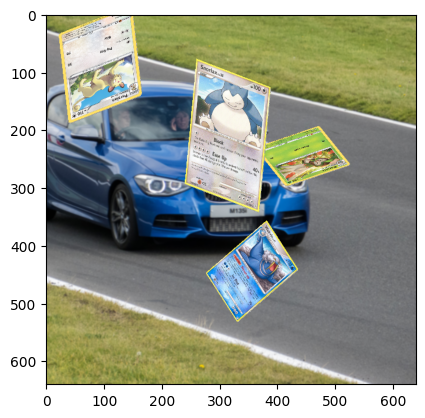

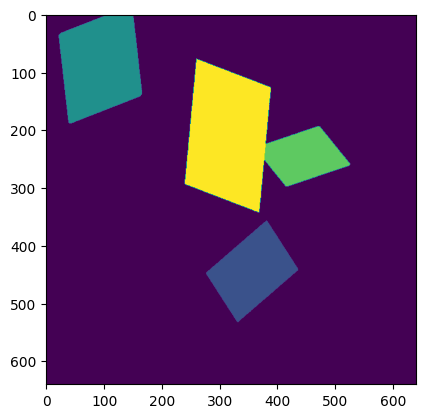

True

In [ ]:
# Example of image generation
img, mask = get_rand_card(files_objs)
img_comp, mask_comp = get_rand_bg(files_bgs)
img_comp, mask_comp, labels_comp, obj_areas, yolo_polygons = create_composition(files_bgs, files_objs, max_objs=5)

plt.imshow(img_comp)
plt.show()
plt.imshow(mask_comp)
plt.show()

img_bgr = cv2.cvtColor(img_comp, cv2.COLOR_RGBA2BGR)
# cv2.imwrite("test_img.png", img_bgr)

In [ ]:
# Loop for writing multiple images

num_images = 6000
card_count_val = [0] * num_images
for i in range(num_images):
    
    card_count_val[i] = len(labels_comp)
    img_filename = f"data\\validation\\images\image_{str(i).zfill(5)}.png"
    label_filename = f"data\\validation\\labels\image_{str(i).zfill(5)}.txt"

    img, mask = get_rand_card(files_objs)
    img_comp, mask_comp = get_rand_bg(files_bgs)
    img_comp, mask_comp, labels_comp, obj_areas, yolo_polygons = create_composition(files_bgs, files_objs, max_objs=5)
    
    img_bgr = cv2.cvtColor(img_comp, cv2.COLOR_RGBA2BGR)
    cv2.imwrite(img_filename, img_bgr)
    write_yolo_polygons(label_filename, yolo_polygons)

# track distribution of # of cards
with open("card_count.txt", 'w') as f:
    for card in card_count_val:
        f.write(f"{card}\n")

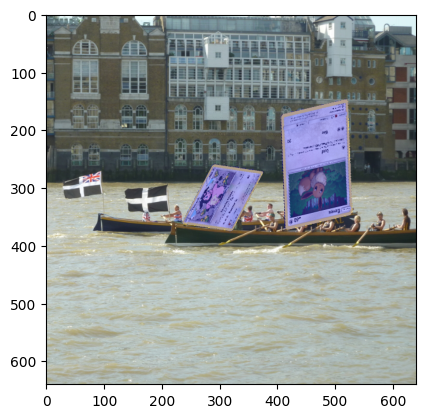

In [ ]:
# Script to test that the mask was converted properly to YOLO format and to visualize the mask from annotation

import cv2
import numpy as np

def yolo_to_mask(label_path, image_shape):
    """
    Converts YOLO polygon labels into a binary mask.
    
    Args:
        label_path (str): Path to YOLO label file.
        image_shape (tuple): (height, width) of the original image.
    
    Returns:
        np.ndarray: Binary mask.
    """
    h, w = image_shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    # Read YOLO label file
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])  # Class ID (optional for visualization)
        points = np.array(parts[1:], dtype=float).reshape(-1, 2)

        # Denormalize points
        points = (points * np.array([w, h])).astype(int)

        # Draw polygon on mask
        cv2.fillPoly(mask, [points], color=255)  # Fill polygon with white (255)

    return mask

def visualize_mask(image_path, mask):
    """
    Visualize the original image with the mask overlaid.
    
    Args:
        image_path (str): Path to the original image.
        mask (np.ndarray): Binary mask.
    """
    # Load original image
    image = cv2.imread(image_path)
    
    # Apply mask as an overlay (red color)
    overlay = image.copy()
    overlay[mask > 0] = [0, 0, 255]  # Red mask

    # Show result
    combined = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)
    plt.imshow(combined)
    plt.show()

# Example usage
image_path = 'data/images/image_00000.png'  # Path to your original image
image_shape = (640, 640)  # Image size (height, width)

mask = yolo_to_mask("data/labels\image_00000.txt", image_shape)
visualize_mask(image_path, mask)